In [51]:
import os
import functools
import cv2 as cv
import skimage.io as io
from PIL import Image
import numpy as np
np.seterr(over='ignore')
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


test-image: 55.png


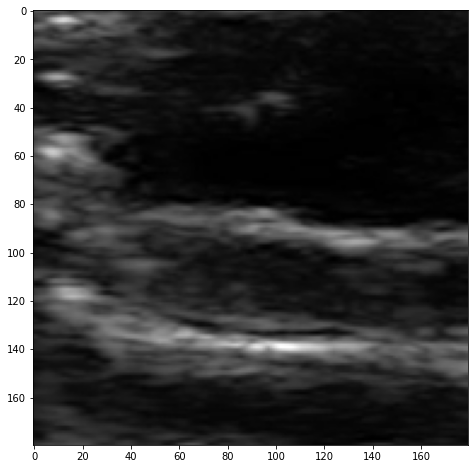

test-image: 60.png


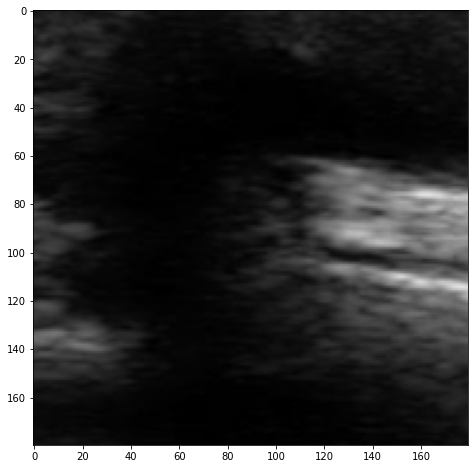

test-image: 157.png


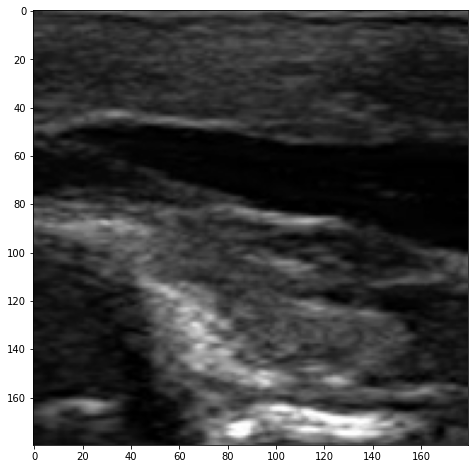

In [52]:
#set the path as where the testing ultrasound images locate, and load the images
test_root_dir = '/content/drive/My Drive/data/US image'
os.chdir(test_root_dir)
root_dir_list=os.listdir(test_root_dir)
root_dir_list.sort(key=lambda x:int(x[:-4]))
# read and display for ultrasound images
for i in root_dir_list:
  img = cv.imread(i)
  print('test-image: '+i)
  plt.figure(figsize=(8,8))
  plt.imshow(img)
  plt.show()

refer-image: 59.png


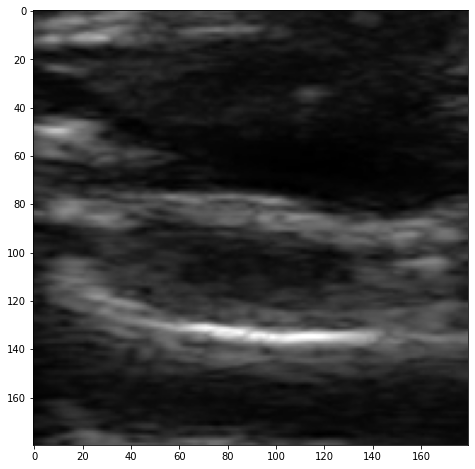

refer-image: 68.png


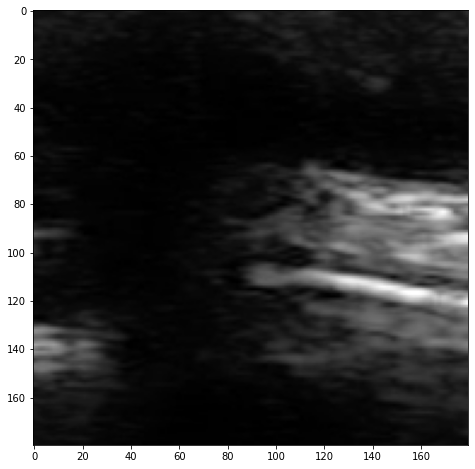

refer-image: 165.png


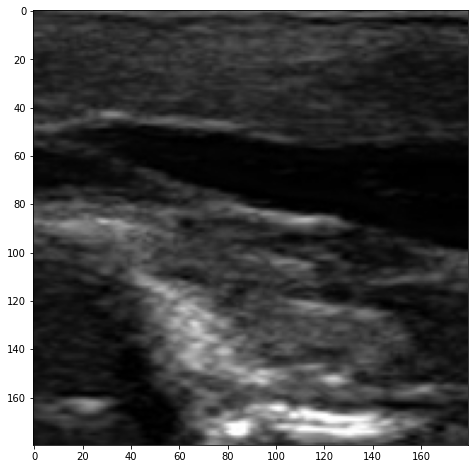

In [53]:
#set the path as where the reference image locate, and load the image
ref_root_dir = '/content/drive/My Drive/data/Ref image'
os.chdir(ref_root_dir)
root_ref_list = os.listdir(ref_root_dir)
root_ref_list.sort(key=lambda x:int(x[:-4]))
# read and display the reference image
for j in root_ref_list:
  ref_img = cv.imread(j)
  print('refer-image: '+j)
  plt.figure(figsize=(8,8))
  plt.imshow(ref_img)
  plt.show()


In [54]:
#creative idea: Adaptive Area Feature Tuning

#return the average brightness of the image
def density_avg(image):
  # obtain the number of rows and cols of the image
  rows = len(image)
  cols = len(image[0])
  total_intensity = 0
  for i in range(rows):
    for j in range(cols):
      total_intensity = total_intensity + image[i][j][0]
  # compute the average brightness
  avg_intensity = total_intensity/(rows*cols)
  print("the average intensity is: "+str(avg_intensity))
  return avg_intensity

#return the coordinates of all keypoints objects
def kpCoordinates(keypoints):
  x_coord = None
  y_coord = None
  coord_list = []
  for kp in keypoints:
    # get the x and y coordinates and cast them as integers
    x_coord = int(kp.pt[0])
    y_coord = int(kp.pt[1])
    coordinate = (x_coord,y_coord)
    coord_list.append(coordinate)
  
  return coord_list

# get the average intensity of the 8 pixels around the keypoint
def localAvgCheck(image,coord):
  x,y = coord
  rows = int(len(image))
  cols = int(len(image[0]))
  # if the point is neither on the borders nor on the corners,
  # then we compute its nearby 8 pixels' average brightness
  if (x!=1 and y!=1 and x!=cols and y!=rows):
    p1 = image[y-1][x-1][0]
    p2 = image[y-1][x][0]
    p3 = image[y-1][x+1][0]
    p4 = image[y][x-1][0]
    p5 = image[y][x+1][0]
    p6 = image[y+1][x-1][0]
    p7 = image[y+1][x][0]
    p8 = image[y+1][x+1][0]
    local_avg = (p1+p2+p3+p4+p5+p6+p7+p8)/8
  # if the point is on the left border,
  # then we compute its nearby 5 pixels' average brightness  
  elif (x==1 and y!=1 and y<rows):
    p1 = image[y-1][x][0]
    p2 = image[y-1][x+1][0]
    p3 = image[y][x+1][0]
    p4 = image[y+1][x][0]
    p5 = image[y+1][x+1][0]
    local_avg = (p1+p2+p3+p4+p5)/5
  # if the point is on the right border,
  # then we compute its nearby 5 pixels' average brightness  
  elif (x==cols and y!=1 and y<rows):
    p1 = image[y-1][x-1][0]
    p2 = image[y-1][x][0]
    p3 = image[y][x-1][0]
    p4 = image[y+1][x-1][0]
    p5 = image[y+1][x][0]
    local_avg = (p1+p2+p3+p4+p5)/5
  # if the point is on the top border,
  # then we compute its nearby 5 pixels' average brightness
  elif (x!=1 and y==1 and x<cols):
    p1 = image[y][x-1][0]
    p2 = image[y][x+1][0]
    p3 = image[y+1][x-1][0]
    p4 = image[y+1][x][0]
    p5 = image[y+1][x+1][0]
    local_avg = (p1+p2+p3+p4+p5)/5
  # if the point is on the top border,
  # then we compute its nearby 5 pixels' average brightness
  elif (x!=1 and y==rows and x<cols):
    p1 = image[y][x-1][0]
    p2 = image[y][x+1][0]
    p3 = image[y-1][x-1][0]
    p4 = image[y-1][x][0]
    p5 = image[y-1][x+1][0]
    local_avg = (p1+p2+p3+p4+p5)/5
  # if the point is on the top left corner,
  # then we compute its nearby 3 pixels' average brightness  
  elif (x==1 and y==1):
    p1 = image[y][x+1][0]
    p2 = image[y+1][x+1][0]
    p3 = image[y+1][x][0]
    local_avg = (p1+p2+p3)/3
  # if the point is on the top right corner,
  # then we compute its nearby 3 pixels' average brightness  
  elif (x==cols and y==1):
    p1 = image[y+1][x][0]
    p2 = image[y+1][x-1][0]
    p3 = image[y][x-1][0]
    local_avg = (p1+p2+p3)/3
  # if the point is on the bottom left corner,
  # then we compute its nearby 3 pixels' average brightness  
  elif (x==1 and y==rows):
    p1 = image[y][x+1][0]
    p2 = image[y-1][x][0]
    p3 = image[y-1][x+1][0]
    local_avg = (p1+p2+p3)/3
  # if the point is on the bottom right corner,
  # then we compute its nearby 3 pixels' average brightness  
  elif (x==cols and y==rows):
    p1 = image[y-1][x-1][0]
    p2 = image[y-1][x][0]
    p3 = image[y][x-1][0]
    local_avg = (p1+p2+p3)/3
  return local_avg
# this is the noisy feature points removal function 
def kpReduce(image,keypoints,threshold,image_avg):
  reduced_num = 0
  # obtain the coordinates of the feature points
  coord_list = kpCoordinates(keypoints)
  # if the feature point's neighbors' average brightness is lower than the image average,
  # and the feature point's brightness is lower than the neighbors' average brightness plus a threshold,
  # then remove the feature point
  for coord in coord_list[:]:
    (x,y) = coord
    localAvgI = localAvgCheck(image,coord)
    if localAvgI < image_avg and image[y][x][0]<localAvgI+threshold:
      coord_list.remove(coord)
      reduced_num += 1
  
  return coord_list,reduced_num

# This is the function to check whether a non-feature pixel satisfy the adding reqirements
def addCheck(coord,image,threshold,image_avg):
  check = False
  local_avg = localAvgCheck(image,coord)
  (x,y) = coord
  # if the pixel's brightness is larger than the image average plus a threshold,
  # and the pixel's neighbors' average brightness is larger than or equal to the image average,
  # then we set the point as a key point
  if image[y][x][0]>=(image_avg+threshold) and local_avg >= image_avg:
    check = True
  
  return check

# This is the function for feature points adding and gathering at bright regions
def kpAdd(image,coord_list,threshold,image_avg):
  added_num = 0
  lista = []
  rows = int(len(image))
  cols = int(len(image[0]))
  for i in range(1,rows-1):
    lista = []
    for j in range(1,cols-1):
      # for each non-feature pixel point
      if (j,i) not in coord_list:
        potential_new = (j,i)
        #print(potential_new)
        # check whether it satisfy the adding requirements
        addcheck = addCheck(potential_new,image,threshold,image_avg)
        lista.append(potential_new)
        # if yes, add it as a new feature point
        if addcheck:
          coord_list.append(potential_new)
          added_num += 1
    
  # convert all coordinates to KeyPoint objects
  new_kp = np.array(coord_list)
  new_kp = [cv.KeyPoint(new_kp[i][0], new_kp[i][1], 1)
          for i in range(new_kp.shape[0])]
  return new_kp,added_num



original feature points for test-images: 55.png


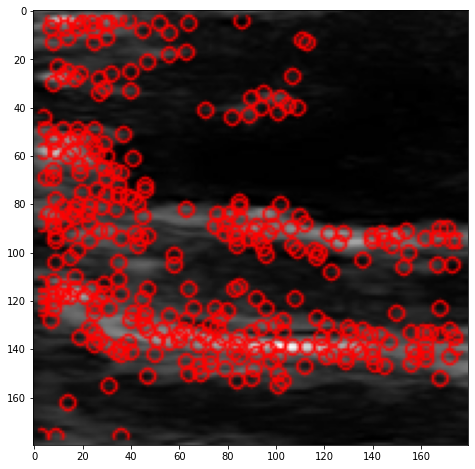

original feature points for test-images: 60.png


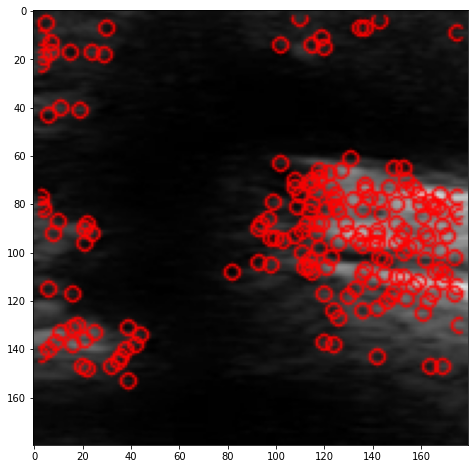

original feature points for test-images: 157.png


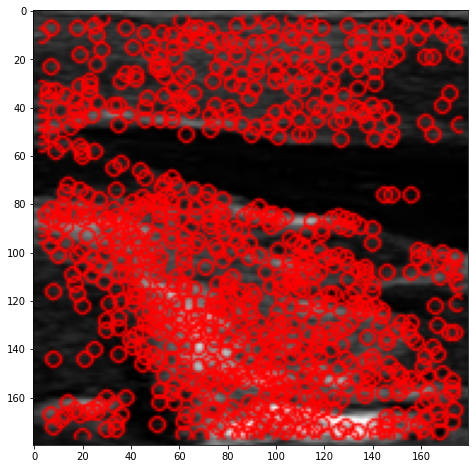

In [55]:
''' obtain the original feature points of all test images'''
os.chdir(test_root_dir)
root_dir_list=os.listdir(test_root_dir)
root_dir_list.sort(key=lambda x:int(x[:-4]))
fast = cv.FastFeatureDetector_create()
# for each ultrasound image
for i in root_dir_list:
  img = cv.imread(i)
  # detect the feature points
  kp = fast.detect(img, None)
  kp_img = cv.drawKeypoints(img, kp, None, color=(255,0,0))
  print('original feature points for test-images: ' +i)
  # plot the feature points on the image and display the image
  plt.figure(figsize=(8,8))
  plt.imshow(kp_img)
  plt.show()

#select the matching test image
test_img_idx = root_dir_list[1]
test_img = cv.imread(test_img_idx)


original feature points for reference-images: 59.png


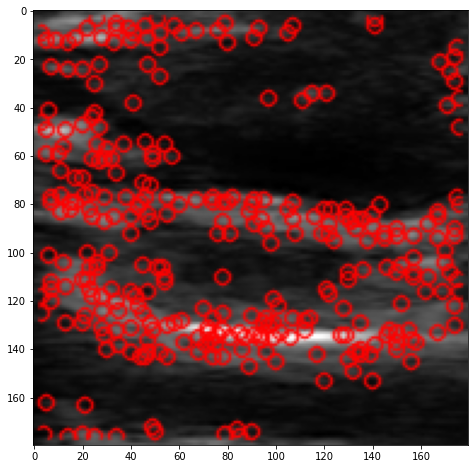

original feature points for reference-images: 68.png


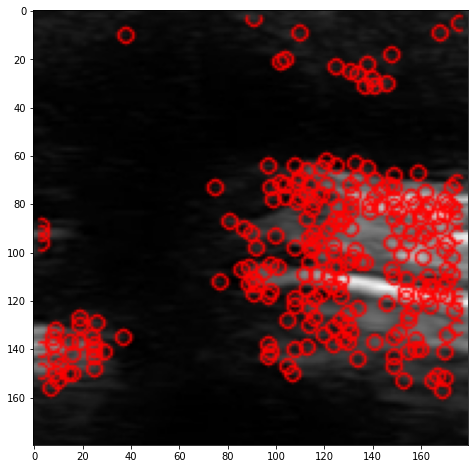

original feature points for reference-images: 165.png


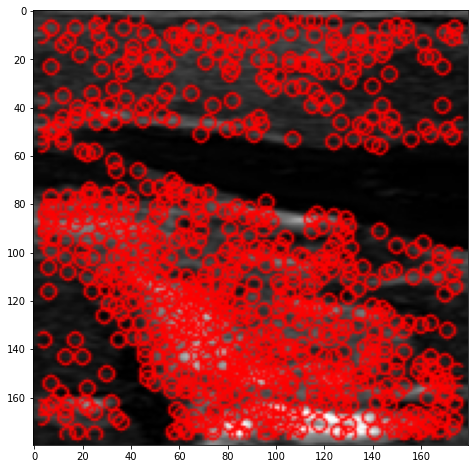

In [56]:
''' obtain the original feature points of all reference images'''
os.chdir(ref_root_dir)
root_ref_list = os.listdir(ref_root_dir)
root_ref_list.sort(key=lambda x:int(x[:-4]))
fast = cv.FastFeatureDetector_create()
# for each reference image
for i in root_ref_list:
  r_img = cv.imread(i)
  # detect the feature points
  kp_r = fast.detect(r_img, None)
  kp_img_r = cv.drawKeypoints(r_img, kp_r, None, color=(255,0,0))
  print('original feature points for reference-images: ' +i)
  # plot the feature points on the image and display the image
  plt.figure(figsize=(8,8))
  plt.imshow(kp_img_r)
  plt.show()

# select the reference matching image
ref_img_idx = root_ref_list[1]
ref_img = cv.imread(ref_img_idx)


the average intensity is: 26.554475308641976
reduce: 40
added: 932


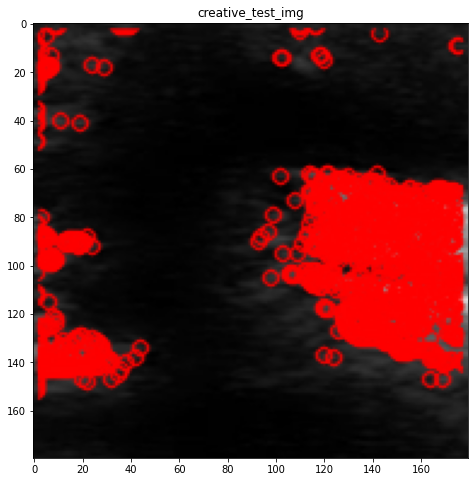

In [57]:
'''Obtain the feature map of the selected test image after the improvement'''

test_kp = fast.detect(test_img,None)
# compute the average brightness of the image
image_avg = density_avg(test_img)

# Perform key points removal for test-image, set the threshold as 30
coord_list,reduced_num = kpReduce(test_img,test_kp,30,image_avg)

# Perform key points adding for test-image, set the threshold as 10
new_keypoints,added_num = kpAdd(test_img,coord_list,10,image_avg)

print('reduce:',reduced_num)
print('added:',added_num)
# draw the feature points on the improved images and the original images
creative_test_img = cv.drawKeypoints(test_img, new_keypoints, None, color=(255,0,0))

plt.figure(figsize=(8,8))
#display the improved images
plt.title('creative_test_img')
plt.imshow(creative_test_img)
plt.show()

the average intensity is: 27.103179012345677
reduce: 69
added: 797


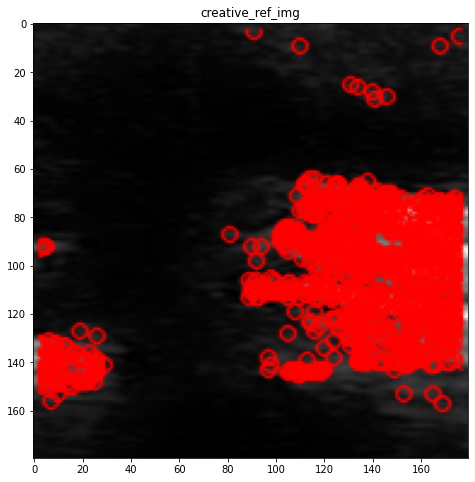

In [58]:
'''Obtain the feature map of the selected reference image after the improvement'''
fast = cv.FastFeatureDetector_create()
ref_kp = fast.detect(ref_img, None)

# compute the average brightness of the image
rimage_avg = density_avg(ref_img)


# Perform key points removal for ref-image, set the threshold as 30
coord_list_r,reduced_num = kpReduce(ref_img,ref_kp,30,rimage_avg)


# Perform key points adding for ref-image, set the threshold as 30
new_keypoints_r,added_num = kpAdd(ref_img,coord_list_r,30,rimage_avg)

print('reduce:',reduced_num)
print('added:',added_num)

# draw the feature points on the improved images and the original images
creative_ref_img = cv.drawKeypoints(ref_img, new_keypoints_r, None, color=(255,0,0))

plt.figure(figsize=(8,8))
# display the improved images
plt.title('creative_ref_img')
plt.imshow(creative_ref_img)
plt.show()



In [59]:
'''This block is to compute the assign descriptors to the feature points using BRIEF'''

# Instantiate the BRIEF descriptor and compute the descriptors
brief =  cv.xfeatures2d.BriefDescriptorExtractor_create(32)
test_kp, descriptors_test = brief.compute(test_img, test_kp)
test2_kp, descriptors_test2 = brief.compute(test_img, new_keypoints)
ref_kp, descriptors_ref = brief.compute(ref_img, ref_kp)
ref2_kp, descriptors_ref2 = brief.compute(ref_img, new_keypoints_r)

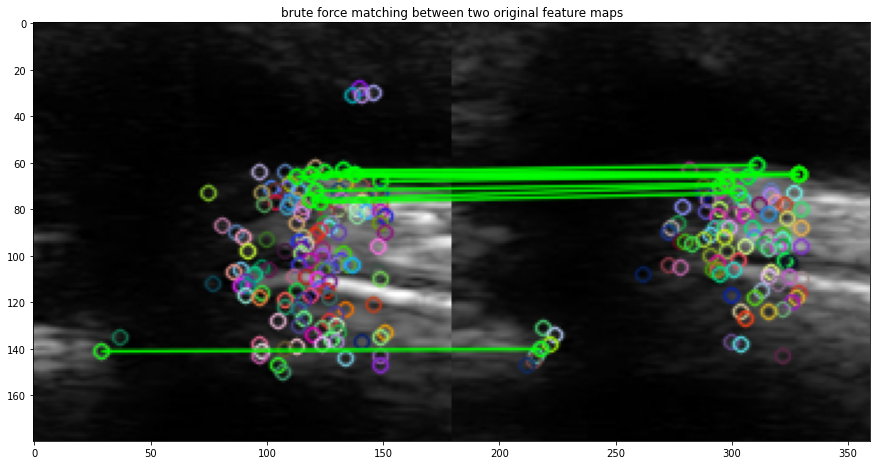

In [60]:
''' This block performs feature matching of two original images using the brute-force matcher, also include the denoising step'''

# Instantiate the brute-force matcher
matcher = cv.BFMatcher_create(cv.NORM_HAMMING)
# Compute the matching points between two original images  
matchePoints = matcher.match(descriptors_ref,descriptors_test)
minMatch = 1
maxMatch = 0
# Shows the distances of the closest matching pairs and the furthest matching pairs
for i in range(len(matchePoints)):
  if  minMatch > matchePoints[i].distance:
    minMatch = matchePoints[i].distance
  if  maxMatch < matchePoints[i].distance:
    maxMatch = matchePoints[i].distance
# Matching denoising
goodMatchePoints = []
# For all matching pairs, if the distance is less than the min_distance + (max_distance-min_distance)/4
# we consider it as a good matching pair
for i in range(len(matchePoints)):
  if matchePoints[i].distance < minMatch + (maxMatch-minMatch)/4:
    goodMatchePoints.append(matchePoints[i])

# draw the matches between two images
matchkp_img = None
match_img = cv.drawMatches(ref_img,ref_kp,test_img,test_kp,goodMatchePoints,matchkp_img,matchColor=(0,255,0),flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)
plt.figure(figsize=(15,15))
# Display the feature points and matchings
plt.title('brute force matching between two original feature maps')
plt.imshow(test_img)
plt.imshow(match_img)
plt.show()

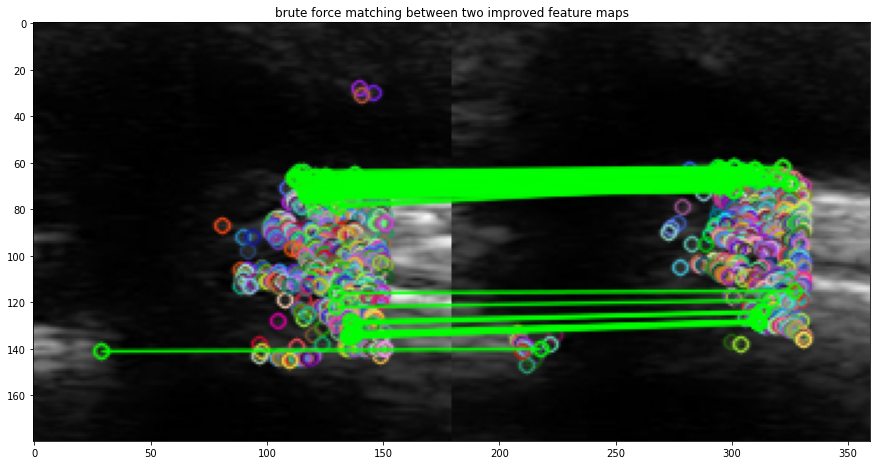

In [61]:
''' This block performs feature matching of two improved images using the brute-force matcher, also include the denoising step'''

# Instantiate the brute-force matcher
matcher = cv.BFMatcher_create(cv.NORM_HAMMING)
# Compute the matching points between two improved images 
matchpoints_new = matcher.match(descriptors_ref2,descriptors_test2)

minMatch = 1
maxMatch = 0
# Shows the distances of the closest matching pairs and the furthest matching pairs
for i in range(len(matchpoints_new)):
  if  minMatch > matchpoints_new[i].distance:
    minMatch = matchpoints_new[i].distance
  if  maxMatch < matchpoints_new[i].distance:
    maxMatch = matchpoints_new[i].distance
# Matching denoising
goodMatchePoints = []
# For all matching pairs, if the distance is less than the min_distance + (max_distance-min_distance)/4
# we consider it as a good matching pair
for i in range(len(matchpoints_new)):
  if matchpoints_new[i].distance < minMatch + (maxMatch-minMatch)/4:
    goodMatchePoints.append(matchpoints_new[i])

# draw the matches between two images
matchkp_img = None
match_img = cv.drawMatches(ref_img,ref2_kp,test_img,test2_kp,goodMatchePoints,matchkp_img,matchColor=(0,255,0),flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)
plt.figure(figsize=(15,15))
# Display the feature points and matchings
plt.title('brute force matching between two improved feature maps')
plt.imshow(test_img)
plt.imshow(match_img)
plt.show()

In [62]:
''' This is the GMS feature matching function. GMS matcher is a more robust feature matcher, it only matches the most similar feature pairs'''
''' Source from https://github.com/JiawangBian/GMS-Feature-Matcher'''

from cv2.xfeatures2d import matchGMS
from enum import Enum

class DrawingType(Enum):
    ONLY_LINES = 1
    LINES_AND_POINTS = 2
    COLOR_CODED_POINTS_X = 3
    COLOR_CODED_POINTS_Y = 4
    COLOR_CODED_POINTS_XpY = 5


def draw_matches(src1, src2, kp1, kp2, matches, drawing_type):
    height = max(src1.shape[0], src2.shape[0])
    width = src1.shape[1] + src2.shape[1]
    output = np.zeros((height, width, 3), dtype=np.uint8)
    output[0:src1.shape[0], 0:src1.shape[1]] = src1
    output[0:src2.shape[0], src1.shape[1]:] = src2[:]

    if drawing_type == DrawingType.ONLY_LINES:
        for i in range(len(matches)):
            left = kp1[matches[i].queryIdx].pt
            right = tuple(sum(x) for x in zip(kp2[matches[i].trainIdx].pt, (src1.shape[1], 0)))
            cv.line(output, tuple(map(int, left)), tuple(map(int, right)), (0, 255, 255))

    elif drawing_type == DrawingType.LINES_AND_POINTS:
        for i in range(len(matches)):
            left = kp1[matches[i].queryIdx].pt
            right = tuple(sum(x) for x in zip(kp2[matches[i].trainIdx].pt, (src1.shape[1], 0)))
            cv.line(output, tuple(map(int, left)), tuple(map(int, right)), (255, 0, 0))

        for i in range(len(matches)):
            left = kp1[matches[i].queryIdx].pt
            right = tuple(sum(x) for x in zip(kp2[matches[i].trainIdx].pt, (src1.shape[1], 0)))
            cv.circle(output, tuple(map(int, left)), 1, (0, 255, 255), 2)
            cv.circle(output, tuple(map(int, right)), 1, (0, 255, 0), 2)

    elif drawing_type == DrawingType.COLOR_CODED_POINTS_X or drawing_type == DrawingType.COLOR_CODED_POINTS_Y or drawing_type == DrawingType.COLOR_CODED_POINTS_XpY:
        _1_255 = np.expand_dims(np.array(range(0, 256), dtype='uint8'), 1)
        _colormap = cv.applyColorMap(_1_255, cv.COLORMAP_HSV)

        for i in range(len(matches)):
            left = kp1[matches[i].queryIdx].pt
            right = tuple(sum(x) for x in zip(kp2[matches[i].trainIdx].pt, (src1.shape[1], 0)))

            if drawing_type == DrawingType.COLOR_CODED_POINTS_X:
                colormap_idx = int(left[0] * 256. / src1.shape[1])  # x-gradient
            if drawing_type == DrawingType.COLOR_CODED_POINTS_Y:
                colormap_idx = int(left[1] * 256. / src1.shape[0])  # y-gradient
            if drawing_type == DrawingType.COLOR_CODED_POINTS_XpY:
                colormap_idx = int((left[0] - src1.shape[1]*.5 + left[1] - src1.shape[0]*.5) * 256. / (src1.shape[0]*.5 + src1.shape[1]*.5))  # manhattan gradient

            color = tuple(map(int, _colormap[colormap_idx, 0, :]))
            cv.circle(output, tuple(map(int, left)), 1, color, 2)
            cv.circle(output, tuple(map(int, right)), 1, color, 2)
    return output

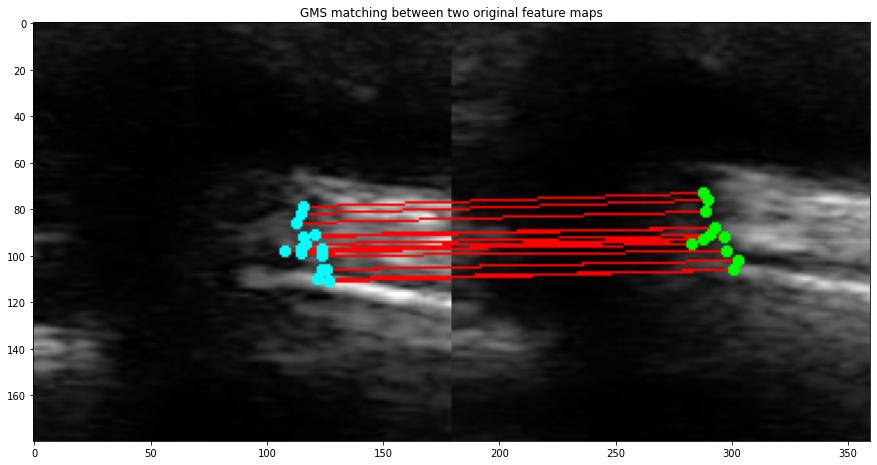

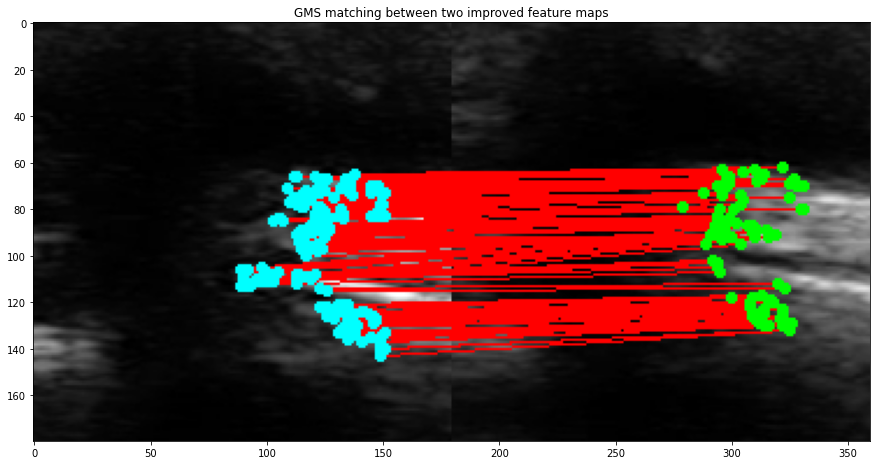

In [63]:
''' Perform GMS matching and show the difference between the original images and improved images'''

from cv2.xfeatures2d import matchGMS

matchpoints_new = matcher.match(descriptors_ref2,descriptors_test2)

# Instantiate the GMS matchers for original images and improved images
matches_gms_1 = matchGMS(ref_img.shape[:2], test_img.shape[:2], ref_kp, test_kp, matchePoints, withScale=False, withRotation=False, thresholdFactor=6)
matches_gms_2 = matchGMS(ref_img.shape[:2], test_img.shape[:2], ref2_kp, test2_kp,matchpoints_new,withScale=False, withRotation=False, thresholdFactor=6)
# draw the most related matches between the two feature maps, and diaplay the matching image
match_img_1 = draw_matches(ref_img,test_img, ref_kp, test_kp, matches_gms_1, DrawingType.LINES_AND_POINTS)
match_img_2 = draw_matches(ref_img,test_img, ref2_kp, test2_kp, matches_gms_2, DrawingType.LINES_AND_POINTS)
plt.figure(figsize=(15,15))
plt.title('GMS matching between two original feature maps')
plt.imshow(match_img_1)
plt.show()
plt.figure(figsize=(15,15))
plt.title('GMS matching between two improved feature maps')
plt.imshow(match_img_2)
plt.show()